<a href="https://colab.research.google.com/github/KCSarkar123/Machine-Learning-Lab-Assignments-/blob/ML-Assignment-1/ML_Assignment1_iris.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ML Lab Assignment-1** (Naive Bayes & Decision Tree on UCI Iris)

---

# Name : Krishna Chandra Sarkar
# Roll : 002211001050


This notebook builds and evaluates multiple classifiers on two UCI datasets using **scikit-learn**:
- Naive Bayes: **GaussianNB**, **MultinomialNB**, **BernoulliNB**
- **DecisionTreeClassifier** (both *gini* and *entropy*)

It reports **Accuracy, Precision, Recall, F1-score** and **Confusion Matrix**, then saves **decision tree images** (with impurity shown) for both criteria.

> Tip: Run all cells top-to-bottom. Outputs (images, CSV) are written to the `outputs/` folder.

In [ ]:

import os, itertools, joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report


RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


OUT_DIR = "outputs"
os.makedirs(OUT_DIR, exist_ok=True)

def ensure_dir(path):
    if not os.path.exists(path):
        os.makedirs(path, exist_ok=True)

In [ ]:

def plot_confusion(cm, classes, title, save_path=None):
    fig, ax = plt.subplots(figsize=(5,4))
    im = ax.imshow(cm, interpolation='nearest')
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes, title=title, ylabel='True', xlabel='Predicted')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center")
    fig.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close(fig)

def compute_metrics(y_true, y_pred, average='weighted'):
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=average, zero_division=0)
    return acc, prec, rec, f1

In [ ]:

iris = datasets.load_iris()
#bc = datasets.load_breast_cancer()

datasets_map = {
    "Iris": (iris.data, iris.target, iris.feature_names, iris.target_names),
    #"BreastCancer": (bc.data, bc.target, bc.feature_names, bc.target_names),
}


splits = {}
for name, (X, y, feat_names, class_names) in datasets_map.items():
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
    )
    splits[name] = {
        "X_train": X_train, "X_test": X_test,
        "y_train": y_train, "y_test": y_test,
        "feature_names": feat_names, "class_names": class_names
    }
print("Datasets prepared:", list(splits.keys()))

Datasets prepared: ['Iris']



[Iris] Tuning GaussianNB ...
Best params: {'clf__var_smoothing': 1e-09}
Test Accuracy: 0.9667 | Precision: 0.9697 | Recall: 0.9667 | F1: 0.9666
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      0.90      0.95        10
   virginica       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



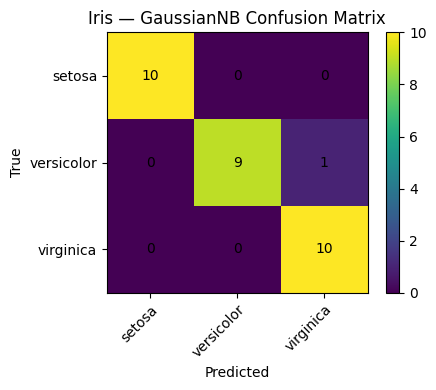


[Iris] Tuning MultinomialNB ...
Best params: {'clf__alpha': 0.1, 'clf__fit_prior': True}
Test Accuracy: 0.8333 | Precision: 0.8350 | Recall: 0.8333 | F1: 0.8329
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.78      0.70      0.74        10
   virginica       0.73      0.80      0.76        10

    accuracy                           0.83        30
   macro avg       0.84      0.83      0.83        30
weighted avg       0.84      0.83      0.83        30



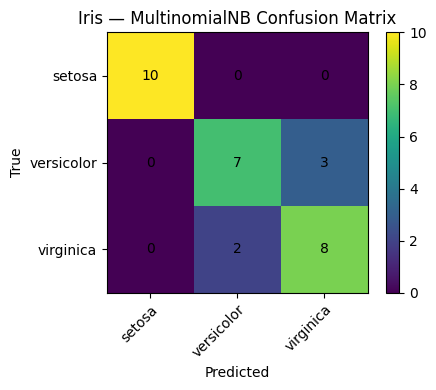


[Iris] Tuning BernoulliNB ...
Best params: {'clf__alpha': 0.1, 'clf__binarize': 0.4}
Test Accuracy: 0.7333 | Precision: 0.8194 | Recall: 0.7333 | F1: 0.6706
              precision    recall  f1-score   support

      setosa       0.83      1.00      0.91        10
  versicolor       1.00      0.20      0.33        10
   virginica       0.62      1.00      0.77        10

    accuracy                           0.73        30
   macro avg       0.82      0.73      0.67        30
weighted avg       0.82      0.73      0.67        30



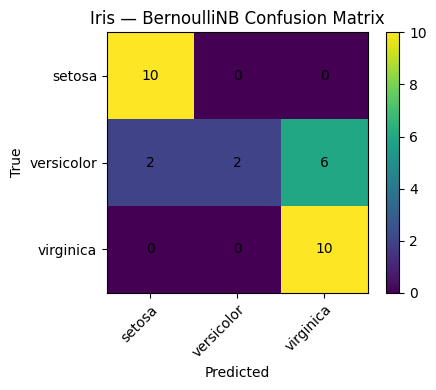


Saved NB summary to: outputs/naive_bayes_results.csv


,dataset,model,best_params,accuracy,precision,recall,f1
0,Iris,GaussianNB,{'clf__var_smoothing': 1e-09},0.966667,0.969697,0.966667,0.966583
1,Iris,MultinomialNB,"{'clf__alpha': 0.1, 'clf__fit_prior': True}",0.833333,0.835017,0.833333,0.832916
2,Iris,BernoulliNB,"{'clf__alpha': 0.1, 'clf__binarize': 0.4}",0.733333,0.819444,0.733333,0.670552


In [ ]:


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

def run_nb_models(dataset_name, split, outdir):
    results = []

    gnb_pipe = Pipeline([('scaler', StandardScaler()), ('clf', GaussianNB())])
    gnb_grid = {'clf__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]}


    mnb_pipe = Pipeline([('scaler', MinMaxScaler()), ('clf', MultinomialNB())])
    mnb_grid = {'clf__alpha': [0.1, 0.5, 1.0, 1.5], 'clf__fit_prior': [True, False]}


    bnb_pipe = Pipeline([('scaler', MinMaxScaler()), ('clf', BernoulliNB())])
    bnb_grid = {'clf__alpha': [0.1, 0.5, 1.0], 'clf__binarize': [0.1, 0.2, 0.3, 0.4, 0.5]}

    configs = [
        ("GaussianNB", gnb_pipe, gnb_grid),
        ("MultinomialNB", mnb_pipe, mnb_grid),
        ("BernoulliNB", bnb_pipe, bnb_grid),
    ]

    X_train, X_test = split["X_train"], split["X_test"]
    y_train, y_test = split["y_train"], split["y_test"]
    class_names = split["class_names"]

    for name, pipe, grid in configs:
        print(f"\n[{dataset_name}] Tuning {name} ...")
        gs = GridSearchCV(pipe, grid, cv=cv, n_jobs=-1, scoring='accuracy', refit=True)
        gs.fit(X_train, y_train)
        y_pred = gs.predict(X_test)
        acc, prec, rec, f1 = compute_metrics(y_test, y_pred)
        print(f"Best params: {gs.best_params_}")
        print(f"Test Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f}")
        print(classification_report(y_test, y_pred, target_names=class_names, zero_division=0))
        cm = confusion_matrix(y_test, y_pred)
        ensure_dir(outdir)
        cm_path = os.path.join(outdir, f"{dataset_name}_{name}_confusion.png")
        plot_confusion(cm, class_names, f"{dataset_name} — {name} Confusion Matrix", save_path=cm_path)
        results.append({
            "dataset": dataset_name, "model": name, "best_params": gs.best_params_,
            "accuracy": acc, "precision": prec, "recall": rec, "f1": f1
        })
    return pd.DataFrame(results)

all_nb_results = []

for dname, split in splits.items():
    outdir = os.path.join(OUT_DIR, dname, "NB")
    df = run_nb_models(dname, split, outdir)
    all_nb_results.append(df)

nb_results = pd.concat(all_nb_results, ignore_index=True)
nb_csv_path = os.path.join(OUT_DIR, "naive_bayes_results.csv")
nb_results.to_csv(nb_csv_path, index=False)
print("\nSaved NB summary to:", nb_csv_path)
nb_results

[Iris] DecisionTree (gini) best params: {'clf__class_weight': None, 'clf__criterion': 'gini', 'clf__max_depth': None, 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 8, 'clf__splitter': 'best'}
Test Accuracy: 0.9667 | Precision: 0.9697 | Recall: 0.9667 | F1: 0.9666


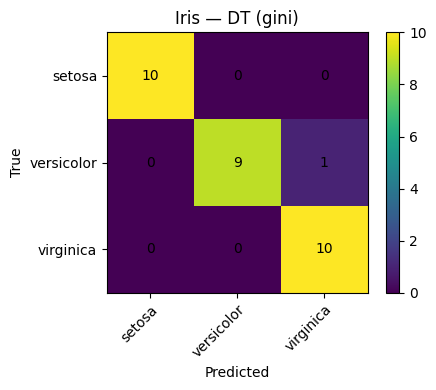

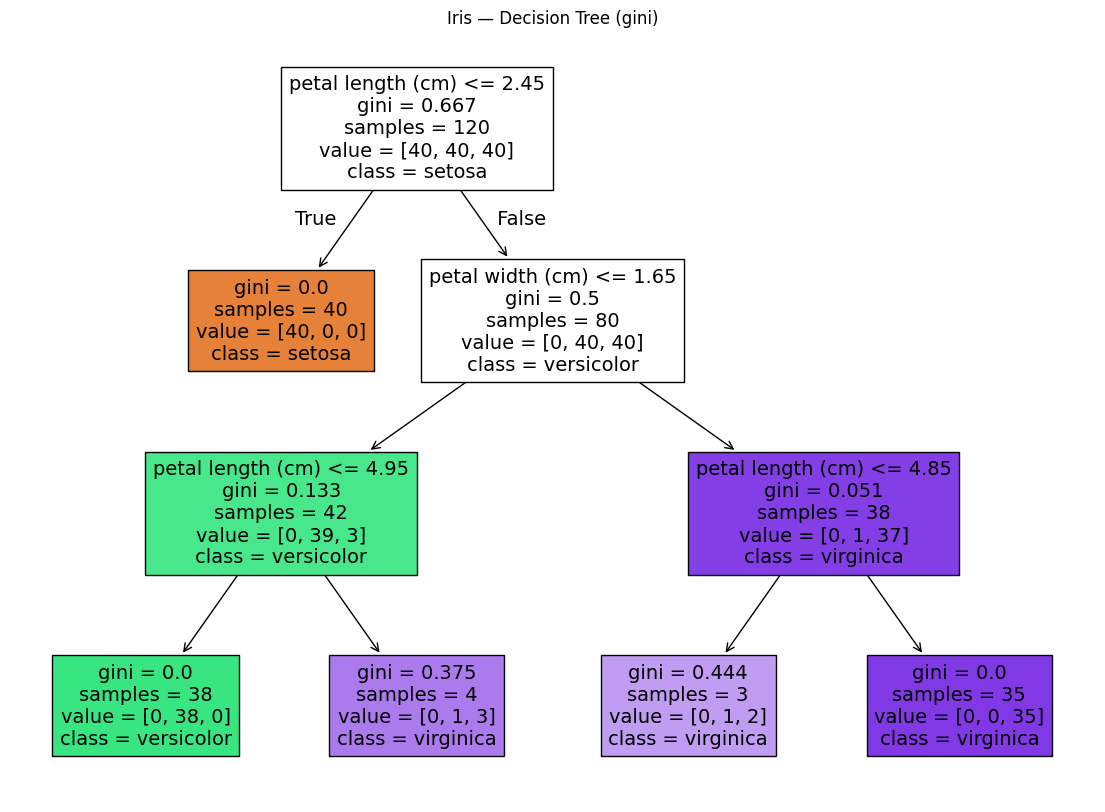

[Iris] DecisionTree (entropy) best params: {'clf__class_weight': None, 'clf__criterion': 'entropy', 'clf__max_depth': None, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 8, 'clf__splitter': 'random'}
Test Accuracy: 0.9333 | Precision: 0.9333 | Recall: 0.9333 | F1: 0.9333


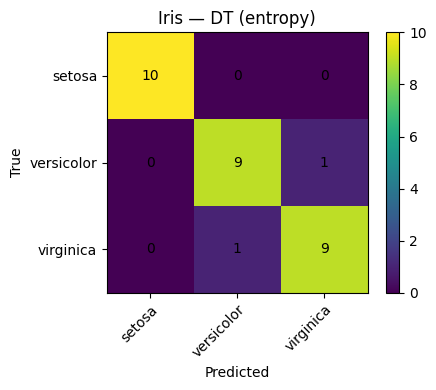

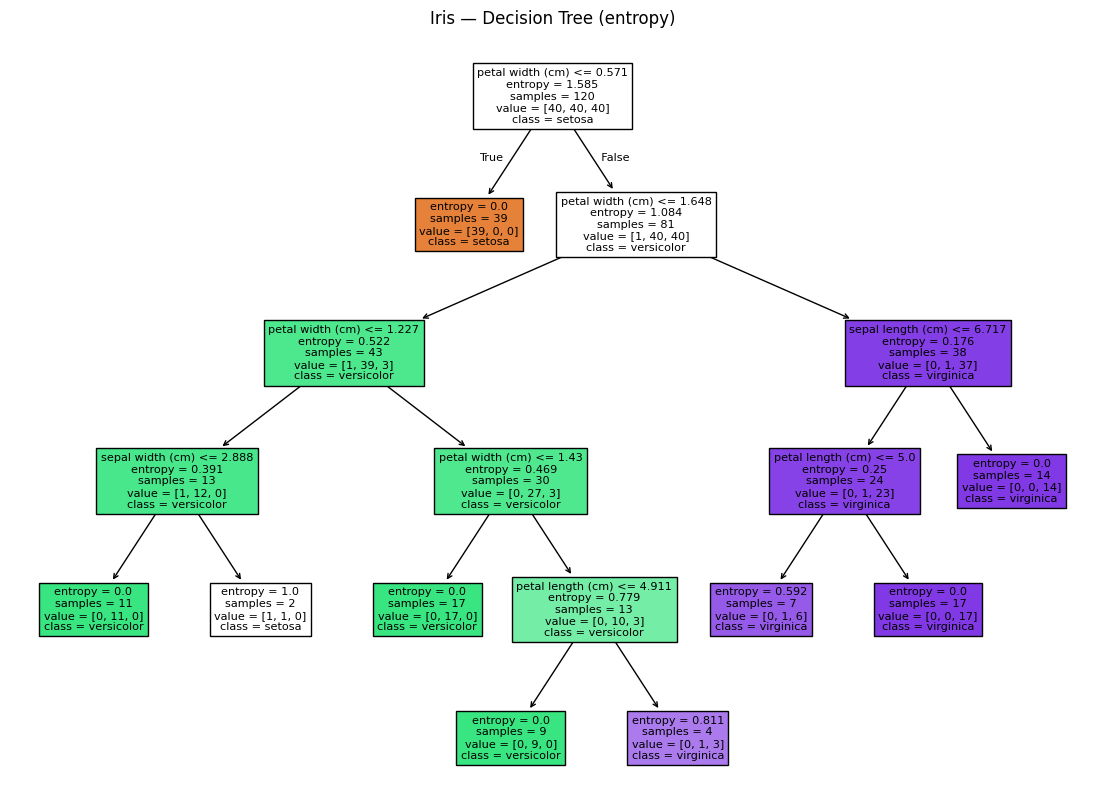


Saved Decision Tree summary to: outputs/decision_tree_results.csv


,dataset,model,best_params,accuracy,precision,recall,f1,tree_image
0,Iris,DecisionTree-gini,"{'clf__class_weight': None, 'clf__criterion': ...",0.966667,0.969697,0.966667,0.966583,outputs/Iris/DecisionTree/Gini/Iris_DT_gini_tr...
1,Iris,DecisionTree-entropy,"{'clf__class_weight': None, 'clf__criterion': ...",0.933333,0.933333,0.933333,0.933333,outputs/Iris/DecisionTree/Entropy/Iris_DT_entr...


In [ ]:


def fit_dt_for_criterion(dataset_name, split, criterion, base_outdir):
    X_train, X_test = split["X_train"], split["X_test"]
    y_train, y_test = split["y_train"], split["y_test"]
    feat_names = split["feature_names"]
    class_names = split["class_names"]

    pipe = Pipeline([('clf', DecisionTreeClassifier(random_state=RANDOM_STATE))])
    grid = {
        'clf__criterion': [criterion],
        'clf__max_depth': [None, 3, 4, 5, 6, 8, 10],
        'clf__min_samples_split': [2, 4, 6, 8, 10],
        'clf__min_samples_leaf': [1, 2, 3, 4],
        'clf__class_weight': [None, 'balanced'],
        'clf__splitter': ['best', 'random']
    }
    gs = GridSearchCV(pipe, grid, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE),
                      n_jobs=-1, scoring='accuracy', refit=True)
    gs.fit(X_train, y_train)
    best_clf = gs.best_estimator_['clf']
    y_pred = gs.predict(X_test)
    acc, prec, rec, f1 = compute_metrics(y_test, y_pred)
    print(f"[{dataset_name}] DecisionTree ({criterion}) best params:", gs.best_params_)
    print(f"Test Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f}")


    cm = confusion_matrix(y_test, y_pred)
    outdir = os.path.join(base_outdir, criterion.capitalize())
    ensure_dir(outdir)
    cm_path = os.path.join(outdir, f"{dataset_name}_DT_{criterion}_confusion.png")
    plot_confusion(cm, class_names, f"{dataset_name} — DT ({criterion})", save_path=cm_path)


    fig, ax = plt.subplots(figsize=(14, 10))
    plot_tree(best_clf, feature_names=feat_names, class_names=class_names, filled=True, impurity=True)
    ax.set_title(f"{dataset_name} — Decision Tree ({criterion})")
    tree_img_path = os.path.join(outdir, f"{dataset_name}_DT_{criterion}_tree.png")
    plt.savefig(tree_img_path, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close(fig)

    return {
        "dataset": dataset_name, "model": f"DecisionTree-{criterion}",
        "best_params": gs.best_params_, "accuracy": acc, "precision": prec, "recall": rec, "f1": f1,
        "tree_image": tree_img_path
    }

dt_rows = []
for dname, split in splits.items():
    base_out = os.path.join(OUT_DIR, dname, "DecisionTree")
    ensure_dir(base_out)
    for crit in ["gini", "entropy"]:
        row = fit_dt_for_criterion(dname, split, crit, base_out)
        dt_rows.append(row)

dt_results = pd.DataFrame(dt_rows)
dt_csv_path = os.path.join(OUT_DIR, "decision_tree_results.csv")
dt_results.to_csv(dt_csv_path, index=False)
print("\nSaved Decision Tree summary to:", dt_csv_path)
dt_results


=== Train/Test Split: 60-40 ===
Iris → Train: 90, Test: 60

[Iris] Tuning GaussianNB ...
Best params: {'clf__var_smoothing': 1e-09}
Test Accuracy: 0.9333 | Precision: 0.9360 | Recall: 0.9333 | F1: 0.9332

=== Train/Test Split: 50-50 ===
Iris → Train: 75, Test: 75

[Iris] Tuning GaussianNB ...
Best params: {'clf__var_smoothing': 1e-09}
Test Accuracy: 0.9467 | Precision: 0.9485 | Recall: 0.9467 | F1: 0.9466

=== Train/Test Split: 30-70 ===
Iris → Train: 45, Test: 105

[Iris] Tuning GaussianNB ...
Best params: {'clf__var_smoothing': 1e-09}
Test Accuracy: 0.9524 | Precision: 0.9526 | Recall: 0.9524 | F1: 0.9524

=== Train/Test Split: 80-20 ===
Iris → Train: 120, Test: 30

[Iris] Tuning GaussianNB ...
Best params: {'clf__var_smoothing': 1e-09}
Test Accuracy: 0.9667 | Precision: 0.9697 | Recall: 0.9667 | F1: 0.9666


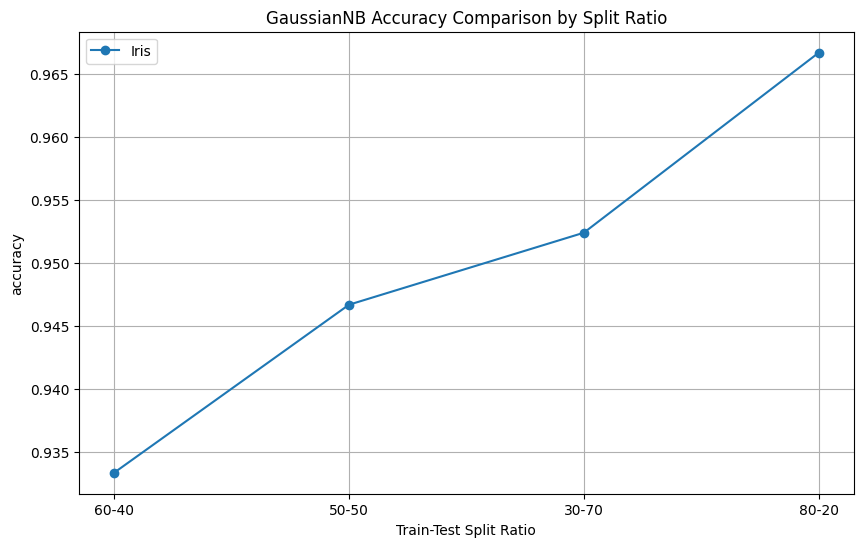

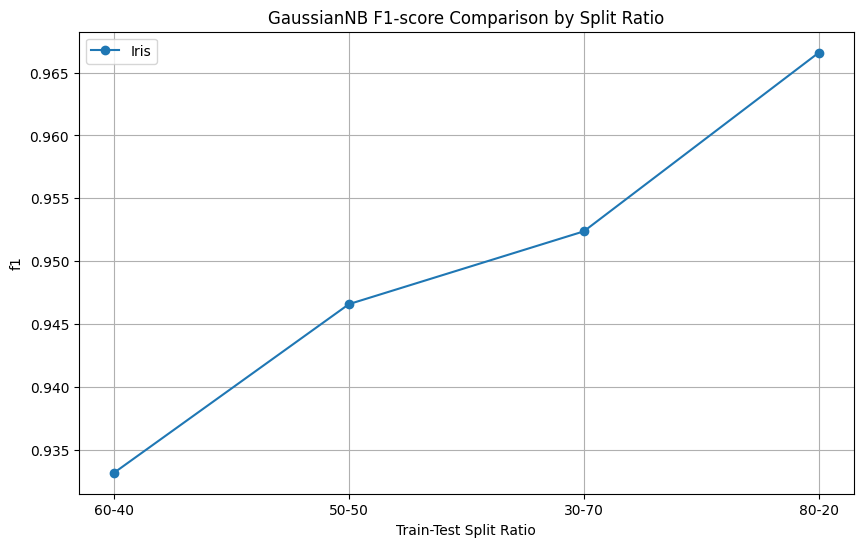


Saved GaussianNB split results to: outputs/gaussiannb_split_results.csv


,dataset,model,best_params,accuracy,precision,recall,f1,split_ratio
0,Iris,GaussianNB,{'clf__var_smoothing': 1e-09},0.933333,0.936027,0.933333,0.933166,60-40
1,Iris,GaussianNB,{'clf__var_smoothing': 1e-09},0.946667,0.948470,0.946667,0.946581,50-50
2,Iris,GaussianNB,{'clf__var_smoothing': 1e-09},0.952381,0.952614,0.952381,0.952371,30-70
3,Iris,GaussianNB,{'clf__var_smoothing': 1e-09},0.966667,0.969697,0.966667,0.966583,80-20


In [ ]:


split_ratios = [0.4, 0.5, 0.7, 0.2] # Corresponds to test sizes for 60-40, 50-50, 30-70, 80-20 splits

nb_split_results = []

for ratio in split_ratios:
    print(f"\n=== Train/Test Split: {int((1-ratio)*100)}-{int(ratio*100)} ===")
    for name, (X, y, feat_names, class_names) in datasets_map.items():
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=ratio, stratify=y, random_state=RANDOM_STATE
        )
        print(f"{name} → Train: {len(X_train)}, Test: {len(X_test)}")

        # Run GaussianNB
        gnb_pipe = Pipeline([('scaler', StandardScaler()), ('clf', GaussianNB())])
        gnb_grid = {'clf__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]}
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

        print(f"\n[{name}] Tuning GaussianNB ...")
        gs = GridSearchCV(gnb_pipe, gnb_grid, cv=cv, n_jobs=-1, scoring='accuracy', refit=True)
        gs.fit(X_train, y_train)
        y_pred = gs.predict(X_test)
        acc, prec, rec, f1 = compute_metrics(y_test, y_pred)
        print(f"Best params: {gs.best_params_}")
        print(f"Test Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f}")

        nb_split_results.append({
            "dataset": name, "model": "GaussianNB", "best_params": gs.best_params_,
            "accuracy": acc, "precision": prec, "recall": rec, "f1": f1,
            "split_ratio": f"{int((1-ratio)*100)}-{int(ratio*100)}"
        })

nb_split_results_df = pd.DataFrame(nb_split_results)


def plot_nb_comparison_chart(df, metric, title):
    plt.figure(figsize=(10, 6))
    for dataset in df['dataset'].unique():
        dataset_data = df[df['dataset'] == dataset]
        plt.plot(dataset_data['split_ratio'], dataset_data[metric], marker='o', label=dataset)

    plt.title(title)
    plt.xlabel('Train-Test Split Ratio')
    plt.ylabel(metric)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_nb_comparison_chart(nb_split_results_df, 'accuracy', 'GaussianNB Accuracy Comparison by Split Ratio')
plot_nb_comparison_chart(nb_split_results_df, 'f1', 'GaussianNB F1-score Comparison by Split Ratio')


nb_split_csv_path = os.path.join(OUT_DIR, "gaussiannb_split_results.csv")
nb_split_results_df.to_csv(nb_split_csv_path, index=False)
print("\nSaved GaussianNB split results to:", nb_split_csv_path)
display(nb_split_results_df)

## What gets saved
- `outputs/naive_bayes_results.csv`
- `outputs/decision_tree_results.csv`
- `outputs/<Dataset>/NB/*confusion.png`
- `outputs/<Dataset>/DecisionTree/Gini/*` (confusion + tree image)
- `outputs/<Dataset>/DecisionTree/Entropy/*` (confusion + tree image)

> You can directly insert these PNGs and CSV summaries into your report.